## Read Input

In [1]:
import cv2
import numpy as np

root_path = input() # '/Users/rachelsidney/Documents/university-of-tokyo/A1A2/remote-sensing-image-analysis/'

lr_red_path = f'{root_path}/input/lr_red.tif'
lr_green_path = f'{root_path}/input/lr_green.tif'
lr_blue_path = f'{root_path}/input/lr_blue.tif'
lr_nir_path = f'{root_path}/input/lr_nir.tif'

pan_path = f'{root_path}/input/pan.tif'

lr_red_img = cv2.imread(lr_red_path, -1)
lr_green_img = cv2.imread(lr_green_path, -1)
lr_blue_img = cv2.imread(lr_blue_path, -1)
lr_nir_img = cv2.imread(lr_nir_path, -1)

pan_img = cv2.imread(pan_path, -1)

lr_red_arr = np.asarray(lr_red_img)
lr_green_arr = np.asarray(lr_green_img)
lr_blue_arr = np.asarray(lr_blue_img)
lr_nir_arr = np.asarray(lr_nir_img)

pan_arr = np.asarray(pan_img)

print(f'lr_red_arr dimension: {lr_red_arr.shape}')
print(f'lr_green_arr dimension: {lr_green_arr.shape}')
print(f'lr_blue_arr dimension: {lr_blue_arr.shape}')
print(f'lr_nir_arr dimension: {lr_nir_arr.shape}')
print(f'pan_arr dimension: {pan_arr.shape}')

/Users/rachelsidney/Documents/university-of-tokyo/A1A2/remote-sensing-image-analysis/
lr_red_arr dimension: (300, 300)
lr_green_arr dimension: (300, 300)
lr_blue_arr dimension: (300, 300)
lr_nir_arr dimension: (300, 300)
pan_arr dimension: (1200, 1200)


## Show Input

lr_red_img:


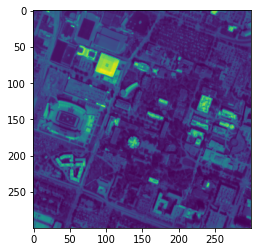

lr_green_img:


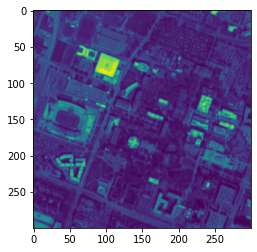

lr_blue_img:


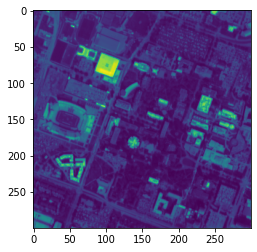

lr_nir_img:


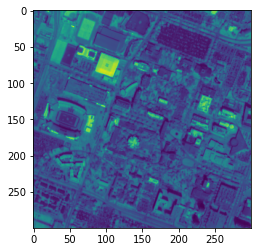

In [2]:
import matplotlib.pyplot as plt

print('lr_red_img:')
plt.imshow(lr_red_img)
plt.show()

print('lr_green_img:')
plt.imshow(lr_green_img)
plt.show()

print('lr_blue_img:')
plt.imshow(lr_blue_img)
plt.show()

print('lr_nir_img:')
plt.imshow(lr_nir_img)
plt.show()

## Upsampling

In [3]:
scale_x = pan_arr.shape[0] / lr_red_arr.shape[0]
scale_y = pan_arr.shape[1] / lr_red_arr.shape[1]

lr_red_upsampled_img = cv2.resize(lr_red_img, None, fx = scale_x, fy = scale_y, interpolation = cv2.INTER_CUBIC)
lr_green_upsampled_img = cv2.resize(lr_green_img, None, fx = scale_x, fy = scale_y, interpolation = cv2.INTER_CUBIC)
lr_blue_upsampled_img = cv2.resize(lr_blue_img, None, fx = scale_x, fy = scale_y, interpolation = cv2.INTER_CUBIC)
lr_nir_upsampled_img = cv2.resize(lr_nir_img, None, fx = scale_x, fy = scale_y, interpolation = cv2.INTER_CUBIC)

lr_red_upsampled_arr = np.asarray(lr_red_upsampled_img)
lr_green_upsampled_arr = np.asarray(lr_green_upsampled_img)
lr_blue_upsampled_arr = np.asarray(lr_blue_upsampled_img)
lr_nir_upsampled_arr = np.asarray(lr_nir_upsampled_img)

print(f'lr_red_upsampled_arr dimension: {lr_red_upsampled_arr.shape}')
print(f'lr_green_upsampled_arr dimension: {lr_green_upsampled_arr.shape}')
print(f'lr_blue_upsampled_arr dimension: {lr_blue_upsampled_arr.shape}')
print(f'lr_nir_upsampled_arr dimension: {lr_nir_upsampled_arr.shape}')

lr_red_upsampled_arr dimension: (1200, 1200)
lr_green_upsampled_arr dimension: (1200, 1200)
lr_blue_upsampled_arr dimension: (1200, 1200)
lr_nir_upsampled_arr dimension: (1200, 1200)


## Upsampling Result

lr_red_upsampled_img: 


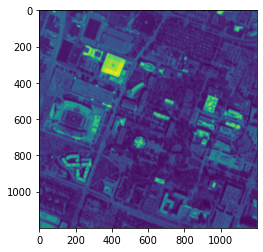

lr_green_upsampled_img: 


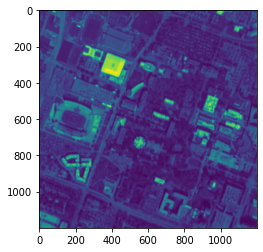

lr_blue_upsampled_img: 


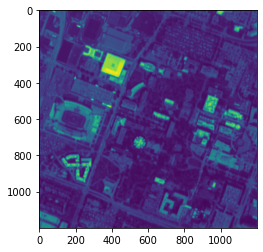

lr_nir_upsampled_img: 


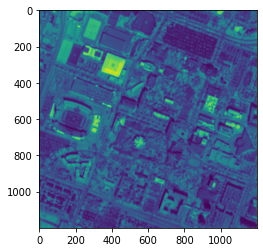

In [4]:
print('lr_red_upsampled_img: ')
plt.imshow(lr_red_upsampled_img)
plt.show()

print('lr_green_upsampled_img: ')
plt.imshow(lr_green_upsampled_img)
plt.show()

print('lr_blue_upsampled_img: ')
plt.imshow(lr_blue_upsampled_img)
plt.show()

print('lr_nir_upsampled_img: ')
plt.imshow(lr_nir_upsampled_img)
plt.show()

## Pan-sharpening using PCA Algorithm

In [5]:
def PCA(X, no_dims):
    mapping = {}
    
    # calculate mean of elements for each band
    mapping['mean'] = np.ma.mean(X, axis = 0)

    # column-wise zero empirical mean
    X = X - mapping['mean']

    # covariance matrix, row = observations, column = variables
    C = np.ma.cov(X, rowvar=False)

    # eigenvalue decomposition
    eigenvalues, M = np.linalg.eigh(C, UPLO = 'U')
    ind = np.arange(0, eigenvalues.shape[0], 1)
    ind = np.flip(ind)
    
    # flip M in each row so that the first axis becomes the highest variance
    M = M[:, ind[0:no_dims]]
    eigenvalues = eigenvalues[0:no_dims]

    mappedX = np.ma.dot(X, M)

    mapping['M'] = M
    mapping['lambda'] = eigenvalues

    return (mappedX, mapping)

def inversePCA(E, P, MeanV):
    return np.ma.dot(P, E.T) + MeanV

row_number, col_number = pan_arr.shape

image = np.zeros((row_number, col_number, 4))
image[:,:,0] = lr_red_upsampled_arr
image[:,:,1] = lr_green_upsampled_arr
image[:,:,2] = lr_blue_upsampled_arr
image[:,:,3] = lr_nir_upsampled_arr

m, n, d = image.shape

M = np.reshape(image, (m * n, d))
PCAData, PCAMap = PCA(M, d)
PCAData = np.reshape(PCAData, (m, n, d))
F = PCAData
PC1 = (pan_arr - pan_arr.mean()) * (F[:,:,0].std() / pan_arr.std()) + F[:,:,0].mean()
F[:,:,0] = PC1
F = inversePCA(PCAMap['M'], np.reshape(F, (m * n, d)), PCAMap['mean'])
sharpened = np.reshape(F, (m, n, d))

red_arr = sharpened[:,:,0]
green_arr = sharpened[:,:,1]
blue_arr = sharpened[:,:,2]
nir_arr = sharpened[:,:,3]


red_arr_uint16 = np.clip(red_arr, 0, np.iinfo(np.uint16).max).astype(np.uint16)
green_arr_uint16 = np.clip(green_arr, 0, np.iinfo(np.uint16).max).astype(np.uint16)
blue_arr_uint16 = np.clip(blue_arr, 0, np.iinfo(np.uint16).max).astype(np.uint16)
nir_arr_uint16 = np.clip(nir_arr, 0, np.iinfo(np.uint16).max).astype(np.uint16)

## Pan-sharpening Result

red_arr_uint16: 


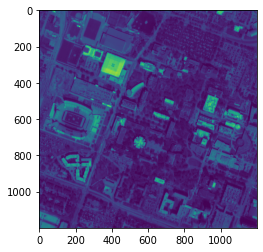

green_arr_uint16: 


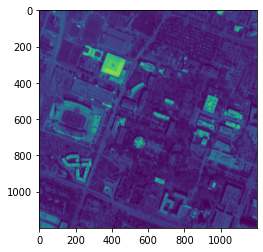

blue_arr_uint16: 


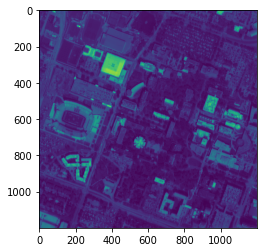

nir_arr_uint16: 


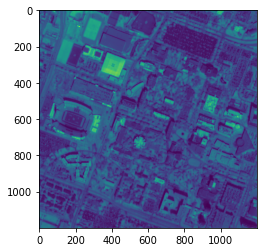

In [6]:
import matplotlib.pyplot as plt

print('red_arr_uint16: ')
plt.imshow(red_arr_uint16)
plt.show()

print('green_arr_uint16: ')
plt.imshow(green_arr_uint16)
plt.show()

print('blue_arr_uint16: ')
plt.imshow(blue_arr_uint16)
plt.show()

print('nir_arr_uint16: ')
plt.imshow(nir_arr_uint16)
plt.show()

## Write Result

In [7]:
import zipfile

cv2.imwrite('output/red.tif', red_arr_uint16)
cv2.imwrite('output/green.tif', green_arr_uint16)
cv2.imwrite('output/blue.tif', blue_arr_uint16)
cv2.imwrite('output/nir.tif', nir_arr_uint16)

with zipfile.ZipFile(f'{root_path}/output/result.zip', 'w', compression = zipfile.ZIP_DEFLATED) as new_zip:
    new_zip.write('output/red.tif', 'red.tif')
    new_zip.write('output/green.tif', 'green.tif')
    new_zip.write('output/blue.tif', 'blue.tif')
    new_zip.write('output/nir.tif', 'nir.tif')